## This is code for adding

### Imports and preloading

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
path="../../input/dlib_dog_emotion_dataset/train"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)


Reduced Train: 15640


In [3]:
path="../../input/dlib_dog_emotion_dataset/eval"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Train: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Train: 340


In [5]:
from collections import Counter

# Get the list of all targets (i.e., class indices)
targets = [label for _, label in evalSet]

# Count each class
class_counts = Counter(targets)

# Map class indices to names
idx_to_class = {v: k for k, v in evalSet.class_to_idx.items()}

# Print class name and count
for class_idx, count in sorted(class_counts.items()):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {count}")


angry: 87
happy: 129
relaxed: 109
sad: 15


In [4]:
# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)

4


### Code Strucutre

In [6]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

optimizer = optim.Adam(model.base.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

### Training

In [7]:
epochs = 10
best_val_acc = 0.0
patience = 3
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    train_losses.append(epochLoss)

    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    val_acc = eval_correct / eval_total
    val_losses.append(valLoss)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/dlib_dog_emotion_dataset/SEafterFeaturesInClassifier.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/10] Loss: 1.0189 Accuracy: 0.6075
Eval  Loss: 1.1169 | Accuracy: 0.5118
Epoch [2/10] Loss: 0.7642 Accuracy: 0.7269
Eval  Loss: 1.0508 | Accuracy: 0.5206
Epoch [3/10] Loss: 0.5773 Accuracy: 0.8018
Eval  Loss: 1.0557 | Accuracy: 0.5088
No improvement. Trigger 1/3
Epoch [4/10] Loss: 0.3948 Accuracy: 0.8888
Eval  Loss: 1.0616 | Accuracy: 0.5206
No improvement. Trigger 2/3
Epoch [5/10] Loss: 0.2452 Accuracy: 0.9513
Eval  Loss: 1.0838 | Accuracy: 0.5176
No improvement. Trigger 3/3
Early stopping triggered.


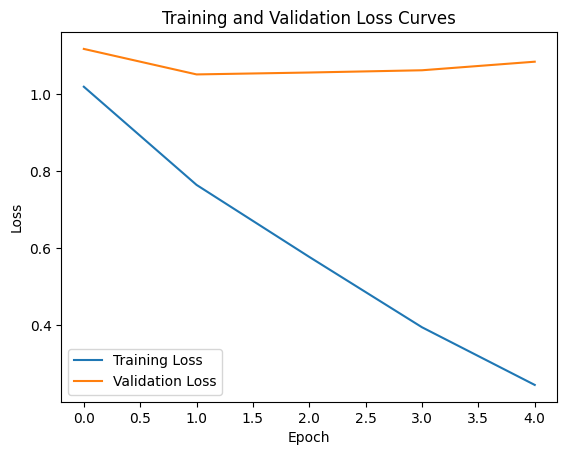

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/dlib_dog_emotion_dataset/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 334


In [10]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [11]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/dlib_dog_emotion_dataset/SEafterFeaturesInClassifier.pth"))
model.eval()


CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [12]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.6916
Classification Report:
              precision    recall  f1-score   support

       angry       0.75      0.58      0.65        85
       happy       0.66      0.80      0.72       128
     relaxed       0.69      0.72      0.71       108
         sad       1.00      0.15      0.27        13

    accuracy                           0.69       334
   macro avg       0.78      0.56      0.59       334
weighted avg       0.71      0.69      0.68       334

Confusion Matrix:
[[ 49  24  12   0]
 [  6 102  20   0]
 [  6  24  78   0]
 [  4   4   3   2]]
